In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and di

## 패키지

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from tqdm import tqdm

import os
os.chdir('/content/drive/MyDrive/dacon_LH')

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=013bdfa270c02c0e7b55ad84d16c695476fb250f8d39d90448ee7a4e01add531
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


## 데이터

In [ ]:
train = pd.read_csv('./data/train.csv', na_values='-')
test = pd.read_csv('./data/test.csv', na_values='-')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0


In [ ]:
# train = train.drop_duplicates()  # 완전히 동일한 행 중복?? -> raw data 상에서는 다른 인스턴스
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철역수', '도보 10분거리 내 버스정류장 수':'버스정류장수'}, inplace=True)
print(len(train))

2952


In [ ]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0


In [ ]:
# test = test.drop_duplicates()  # 완전히 동일한 행 중복?? -> raw data 상에서는 다른 인스턴스
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철역수', '도보 10분거리 내 버스정류장 수':'버스정류장수'}, inplace=True)
print(len(test))

1022


In [ ]:
submission.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   자격유형      2952 non-null   object 
 9   임대보증금     2371 non-null   float64
 10  임대료       2362 non-null   float64
 11  지하철역수     2741 non-null   float64
 12  버스정류장수    2948 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 346.1+ KB


## EDA

In [ ]:
cat_col = ['임대건물구분','지역','공급유형','자격유형']
print(cat_col)

['임대건물구분', '지역', '공급유형', '자격유형']


In [ ]:
for col in cat_col:
  print(col, train[col].unique())

임대건물구분 ['아파트' '상가']
지역 ['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
공급유형 ['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']
자격유형 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O']


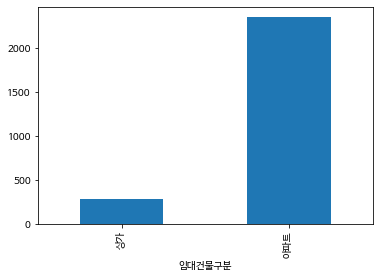

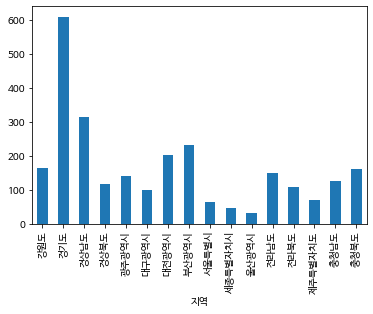

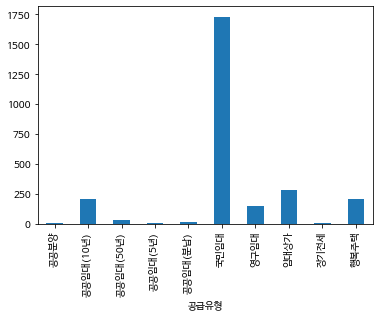

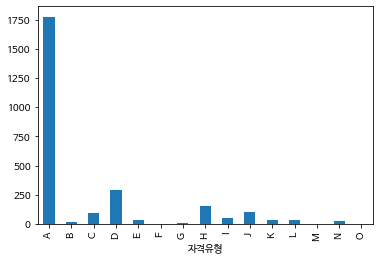

In [ ]:
for col in cat_col:
  train.groupby(col).count()['단지코드'].plot(kind='bar')
  plt.show()

In [ ]:
num_col = train.columns.difference(['단지코드']).difference(cat_col)
print(num_col)

Index(['공가수', '단지내주차면수', '등록차량수', '버스정류장수', '임대료', '임대보증금', '전용면적', '전용면적별세대수',
       '지하철역수', '총세대수'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


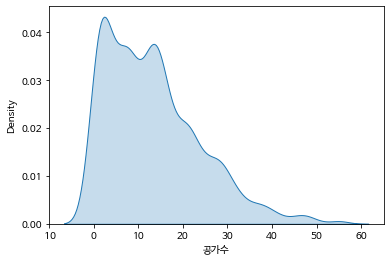

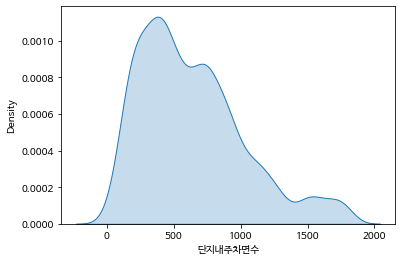

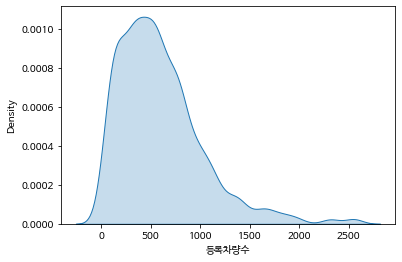

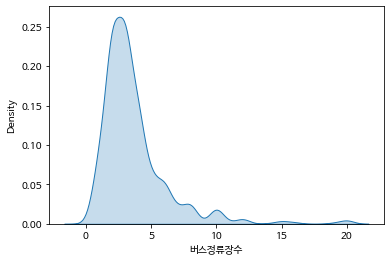

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


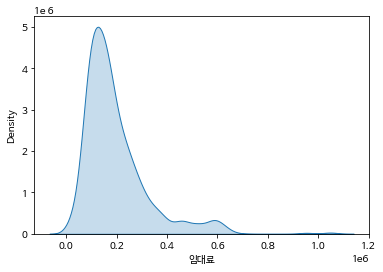

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


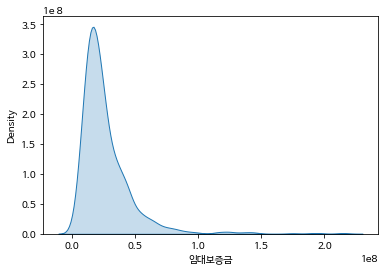

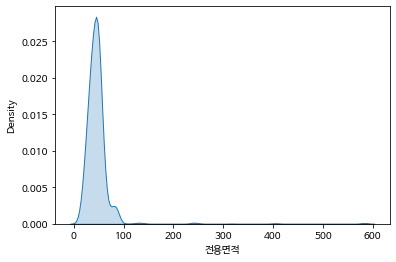

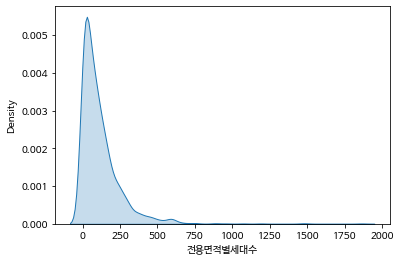

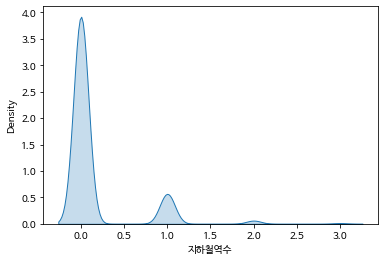

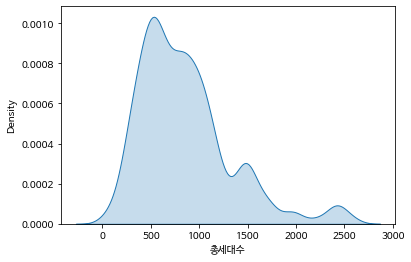

In [ ]:
for col in num_col:
  sns.kdeplot(train[col], shade=True)
  plt.show()

임대료, 임대보증금, 전용면적, 전용면적별세대수 -> 이상치 존재

## 결측치 처리

In [ ]:
train.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       581
임대료         590
지하철역수       211
버스정류장수        4
단지내주차면수       0
등록차량수         0
dtype: int64

In [ ]:
test.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       186
임대료         186
지하철역수        42
버스정류장수        0
단지내주차면수       0
dtype: int64

임대보증금, 임대료 결측치 보간
- 임대건물구분, 지역, 공급유형별 임대료 평균으로 보간
- 해당 그룹 내 임대보증금, 임대료 값이 하나도 없는 경우 존재
- 지역별 임대료 평균으로 한번 더 보간

In [ ]:
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

In [ ]:
# train['임대보증금'] = train['임대보증금'].fillna(train.groupby(['임대건물구분','지역','공급유형'])['임대보증금'].transform('mean'))
# train['임대보증금'] = train['임대보증금'].fillna(train.groupby(['지역'])['임대보증금'].transform('mean'))
# print(train.임대보증금.isnull().sum())

# test['임대보증금'] = test['임대보증금'].fillna(test.groupby(['임대건물구분','지역','공급유형'])['임대보증금'].transform('mean'))
# test['임대보증금'] = test['임대보증금'].fillna(test.groupby(['지역'])['임대보증금'].transform('mean'))
# print(test.임대보증금.isnull().sum())

0
0


In [ ]:
# train['임대료'] = train['임대료'].fillna(train.groupby(['임대건물구분','지역','공급유형'])['임대료'].transform('mean'))
# train['임대료'] = train['임대료'].fillna(train.groupby(['지역'])['임대료'].transform('mean'))
# print(train.임대료.isnull().sum())

# test['임대료'] = test['임대료'].fillna(test.groupby(['임대건물구분','지역','공급유형'])['임대료'].transform('mean'))
# test['임대료'] = test['임대료'].fillna(test.groupby(['지역'])['임대료'].transform('mean'))
# print(test.임대료.isnull().sum())

0
0


지하철역수, 버스정류장 수 결측치 보간

In [ ]:
temp = train.drop_duplicates(['단지코드','지하철역수'])
temp[temp.duplicated(['단지코드'])]  # 하나의 단지에서 지하철역수, 버스정류장수가 null값과 not null값을 동시에 가지는 경우는 없음

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수


In [ ]:
# 지하철역과 버스정류장수의 null값은 0일 가능성이 높으므로 0으로 대치
train[['지하철역수','버스정류장수']] = train[['지하철역수','버스정류장수']].fillna(0)
test[['지하철역수','버스정류장수']] = test[['지하철역수','버스정류장수']].fillna(0)

자격유형 결측치 보간
- 결측치는 test셋에만 존재 (2개)
- 단순 최빈값 대치

In [ ]:
print(train['자격유형'].isnull().sum())
print(test['자격유형'].isnull().sum())

0
2


In [ ]:
train['자격유형'].value_counts()  # 결측치 처리의 기준은 train set / test set은 only transform

A    1801
D     569
H     155
J     114
C      95
I      49
E      37
K      33
L      33
N      30
B      21
G       9
F       3
M       2
O       1
Name: 자격유형, dtype: int64

In [ ]:
test['자격유형'] = test['자격유형'].fillna('A')
print(test['자격유형'].isnull().sum())

0


## 이상치 처리

In [ ]:
train.loc[train['임대료']>= 800000,'임대료'] = 800000
test.loc[test['임대료']>= 800000,'임대료'] = 800000


train.loc[train['임대보증금']>= 170000000, '임대보증금'] = 170000000
test.loc[test['임대보증금']>= 170000000, '임대보증금'] = 170000000


train.loc[train['전용면적']>= 400, '전용면적'] = 400
test.loc[test['전용면적']>= 400, '전용면적'] = 400


train.loc[train['전용면적별세대수']>= 1400, '전용면적별세대수'] = 1400
test.loc[test['전용면적별세대수']>= 1400, '전용면적별세대수'] = 1400

In [ ]:
# test에 없는 행들은 제거
train = train[~(train.지역=='서울특별시') | (train.공급유형=='공공분양') | (train.공급유형=='공공임대(5년)') | (train.공급유형=='장기전세')].reset_index(drop=True)

## 파생변수 생성

임대보증금 / 임대료 로그

In [ ]:
train['임대보증금로그'] = np.log1p(train['임대보증금'])
test['임대보증금로그'] = np.log1p(test['임대보증금'])

In [ ]:
train['임대료로그'] = np.log1p(train['임대료'])
test['임대료로그'] = np.log1p(test['임대료'])

총세대수 범주형화

In [ ]:
def cat_househld(x):
  if x < 500:
    r = 'under 500'
  elif (x >= 500) & (x < 1000):
    r = '500~1000'
  elif (x >= 1000) & (x < 1500):
    r = '1000~1500'
  elif (x >= 1500) & (x < 2000):
    r = '1500~2000'
  else:
    r = 'over 2000'
  
  return r

train['총세대수_그룹'] = train['총세대수'].apply(lambda x: cat_househld(x))
print(train.총세대수_그룹.value_counts())

test['총세대수_그룹'] = test['총세대수'].apply(lambda x: cat_househld(x))
print(test.총세대수_그룹.value_counts())

500~1000     1259
under 500     685
1000~1500     595
1500~2000     236
over 2000     122
Name: 총세대수_그룹, dtype: int64
500~1000     409
under 500    276
1000~1500    253
over 2000     46
1500~2000     38
Name: 총세대수_그룹, dtype: int64


전용면적 변수 범주형화

In [ ]:
train['전용면적'].describe()

count    2897.000000
mean       44.285109
std        27.147289
min        12.620000
25%        32.100000
50%        39.910000
75%        51.490000
max       400.000000
Name: 전용면적, dtype: float64

In [ ]:
def cat_area(x):
  if x < 20:
    r = 'under 20'
  elif (x >= 20) & (x < 40):
    r = '20~40'
  elif (x >= 40) & (x < 60):
    r = '40~60'
  elif (x >= 60) & (x < 80):
    r = '60~80'
  elif (x >= 80) & (x < 100):
    r = '80~100'
  else:
    r = 'over 100'
  
  return r

train['전용면적_그룹'] = train['전용면적'].apply(lambda x: cat_area(x))
print(train.전용면적_그룹.value_counts())

test['전용면적_그룹'] = test['전용면적'].apply(lambda x: cat_area(x))
print(test.전용면적_그룹.value_counts())

20~40       1387
40~60       1263
under 20      81
60~80         70
80~100        68
over 100      28
Name: 전용면적_그룹, dtype: int64
20~40       505
40~60       429
under 20     51
80~100       15
60~80        13
over 100      9
Name: 전용면적_그룹, dtype: int64


단지내주차면수 그룹화

In [ ]:
def cat_parking(x):
  if x < 500:
    r = 'under 500'
  elif (x >= 500) & (x < 1000):
    r = '500~1000'
  elif (x >= 1000) & (x < 1500):
    r = '1000~1500'
  elif (x >= 1500) & (x < 2000):
    r = '1500~2000'
  else:
    r = 'over 2000'
  
  return r

train['단지내주차면수_그룹'] = train['단지내주차면수'].apply(lambda x: cat_parking(x))
print(train.단지내주차면수_그룹.value_counts())

test['단지내주차면수_그룹'] = test['단지내주차면수'].apply(lambda x: cat_parking(x))
print(test.단지내주차면수_그룹.value_counts())

under 500    1421
500~1000     1045
1000~1500     313
1500~2000     118
Name: 단지내주차면수_그룹, dtype: int64
under 500    547
500~1000     334
1000~1500    130
1500~2000     11
Name: 단지내주차면수_그룹, dtype: int64


임대료 대비 보증금

In [ ]:
train['임대료대비보증금'] = train['임대보증금']/(train['임대료']+1)
test['임대료대비보증금'] = test['임대보증금']/(test['임대료']+1)

총세대수 대비 주차면수

In [ ]:
train['총세대수대비주차면수'] = train['단지내주차면수']/train['총세대수']
test['총세대수대비주차면수'] = test['단지내주차면수']/test['총세대수']

면적별세대수 대비 주차면수

In [ ]:
train['면적별세대수대비주차면수'] = train['단지내주차면수']/train['전용면적별세대수']
test['면적별세대수대비주차면수'] = test['단지내주차면수']/test['전용면적별세대수']

대중교통 대비 주차면수

In [ ]:
train['대중교통대비주차면수'] = train['단지내주차면수']/(train['지하철역수']+train['버스정류장수']+1)
test['대중교통대비주차면수'] = test['단지내주차면수']/(test['지하철역수']+test['버스정류장수']+1)

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,임대보증금로그,임대료로그,총세대수_그룹,전용면적_그룹,단지내주차면수_그룹,임대료대비보증금,총세대수대비주차면수,면적별세대수대비주차면수,대중교통대비주차면수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,16.567067,11.549074,500~1000,20~40,1000~1500,151.107725,1.583333,10.634328,356.25
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,16.567067,11.549074,500~1000,20~40,1000~1500,151.107725,1.583333,95.000000,356.25
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,500~1000,40~60,1000~1500,148.124841,1.583333,3.701299,356.25
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,500~1000,40~60,1000~1500,148.124841,1.583333,95.000000,356.25
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,500~1000,40~60,1000~1500,148.124841,1.583333,34.756098,356.25


In [ ]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,임대보증금로그,임대료로그,총세대수_그룹,전용면적_그룹,단지내주차면수_그룹,임대료대비보증금,총세대수대비주차면수,면적별세대수대비주차면수,대중교통대비주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0,16.943586,12.153942,500~1000,20~40,500~1000,120.258532,0.905836,5.887931,227.666667
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0,17.400362,12.428940,500~1000,40~60,500~1000,144.231808,0.905836,22.766667,227.666667
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,17.400362,12.428940,500~1000,40~60,500~1000,144.231808,0.905836,6.098214,227.666667
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,17.400362,12.428940,500~1000,40~60,500~1000,144.231808,0.905836,5.691667,227.666667
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0,17.588203,12.600750,500~1000,40~60,500~1000,146.562617,0.905836,11.383333,227.666667


## 인코딩

In [ ]:
cat_col = ['임대건물구분', '지역', '공급유형', '자격유형', '총세대수_그룹','전용면적_그룹','단지내주차면수_그룹']

In [ ]:
for col in cat_col:
  print(col, train[col].unique(), len(train[col].unique()))

임대건물구분 ['아파트' '상가'] 2
지역 ['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시'] 16
공급유형 ['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '장기전세' '공공분양' '공공임대(분납)'
 '행복주택' '공공임대(5년)'] 10
자격유형 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O'] 15
총세대수_그룹 ['500~1000' '1000~1500' '1500~2000' 'under 500' 'over 2000'] 5
전용면적_그룹 ['20~40' '40~60' '60~80' 'under 20' 'over 100' '80~100'] 6
단지내주차면수_그룹 ['1000~1500' '500~1000' 'under 500' '1500~2000'] 4


In [ ]:
for col in cat_col:
  print(col, test[col].unique(), len(test[col].unique()))

임대건물구분 ['아파트' '상가'] 2
지역 ['경기도' '부산광역시' '전라북도' '경상남도' '충청남도' '대전광역시' '제주특별자치도' '강원도' '울산광역시' '경상북도'
 '충청북도' '광주광역시' '전라남도' '대구광역시' '세종특별자치시'] 15
공급유형 ['국민임대' '영구임대' '임대상가' '공공임대(50년)' '공공임대(10년)' '공공임대(분납)' '행복주택'] 7
자격유형 ['H' 'A' 'E' 'C' 'D' 'G' 'I' 'J' 'K' 'L' 'M' 'N'] 12
총세대수_그룹 ['500~1000' '1000~1500' '1500~2000' 'under 500' 'over 2000'] 5
전용면적_그룹 ['20~40' '40~60' '60~80' 'over 100' 'under 20' '80~100'] 6
단지내주차면수_그룹 ['500~1000' '1000~1500' '1500~2000' 'under 500'] 4


In [ ]:
le = LabelEncoder()

train_enc = train.copy()
test_enc = test.copy()

train_enc['지역'] = le.fit_transform(train_enc['지역'])
test_enc['지역'] = le.transform(test_enc['지역'])
test_enc.head()

array([3, 3, 3, ..., 0, 0, 0])

In [ ]:
ohe = OneHotEncoder(sparse=True)
ohe_df_train = pd.DataFrame()
ohe_df_test = pd.DataFrame()

cat_col.remove('지역')
for col in cat_col:
  
  temp1 = pd.DataFrame(ohe.fit_transform(train_enc[[col]]).toarray(), columns=list(ohe.categories_[0]))
  temp2 = pd.DataFrame(ohe.transform(test_enc[[col]]).toarray(), columns=list(ohe.categories_[0]))

  pca = PCA(n_components=temp1.shape[1])
  temp_pca = pca.fit_transform(temp1)

  cumsum = np.cumsum(pca.explained_variance_ratio_)
  d = np.argmax(cumsum >= 0.95) + 1

  n_pca = PCA(n_components=d)
  train_pca = pd.DataFrame(n_pca.fit_transform(temp1))
  test_pca = pd.DataFrame(n_pca.transform(temp2))

  ohe_df_train = pd.concat([ohe_df_train, train_pca],axis=1)
  ohe_df_test = pd.concat([ohe_df_test, test_pca],axis=1)

ohe_df_train

,0,0,1,2,3,0,1,2,3,4,5,6,7,0,1,2,3
0,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-3.066798e-16,-0.677261,-0.071130,0.002616,-0.000531
1,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-7.250259e-16,-0.677261,-0.071130,0.002616,-0.000531
2,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,5.781752e-16,0.736929,-0.079252,0.002889,-0.000587
3,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-2.838677e-15,0.736929,-0.079252,0.002889,-0.000587
4,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-8.376652e-16,0.736929,-0.079252,0.002889,-0.000587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,6.712595e-18,0.736929,-0.079252,0.002889,-0.000587
2893,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,6.712603e-18,0.736929,-0.079252,0.002889,-0.000587
2894,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,6.712603e-18,0.736929,-0.079252,0.002889,-0.000587
2895,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,6.712603e-18,0.736929,-0.079252,0.002889,-0.000587


In [ ]:
c_name=[]
for i in range(ohe_df_train.shape[1]):
  name = 'pca_' + str(i)
  c_name.append(name)

ohe_df_train.columns = c_name
ohe_df_test.columns = c_name

In [ ]:
train_enc = pd.concat([train_enc,ohe_df_train],axis=1).drop(cat_col,axis=1)
test_enc = pd.concat([test_enc,ohe_df_test],axis=1).drop(cat_col,axis=1)
train_enc.head()

,단지코드,총세대수,지역,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수,등록차량수,임대보증금로그,임대료로그,임대료대비보증금,총세대수대비주차면수,면적별세대수대비주차면수,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16
0,C2483,900,3,39.72,134,38.0,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,16.567067,11.549074,151.107725,1.583333,10.634328,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-3.066798e-16,-0.677261,-0.071130,0.002616,-0.000531
1,C2483,900,3,39.72,15,38.0,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,16.567067,11.549074,151.107725,1.583333,95.000000,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-7.250259e-16,-0.677261,-0.071130,0.002616,-0.000531
2,C2483,900,3,51.93,385,38.0,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,148.124841,1.583333,3.701299,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,5.781752e-16,0.736929,-0.079252,0.002889,-0.000587
3,C2483,900,3,51.93,15,38.0,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,148.124841,1.583333,95.000000,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-2.838677e-15,0.736929,-0.079252,0.002889,-0.000587
4,C2483,900,3,51.93,41,38.0,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,17.122544,12.124488,148.124841,1.583333,34.756098,-0.274349,-0.450399,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.00606,0.001264,0.000653,-8.376652e-16,0.736929,-0.079252,0.002889,-0.000587


## 학습 데이터셋 생성

In [ ]:
y_df = train_enc[['단지코드','등록차량수']].drop_duplicates()
train_enc.drop('등록차량수',axis=1, inplace=True)

print(len(train_enc.단지코드.unique()))
print(len(y_df))

417
417


In [ ]:
y_df.head()

,단지코드,등록차량수
0,C2483,1015.0
8,C2515,205.0
15,C1407,1064.0
26,C1945,730.0
32,C1470,553.0


In [ ]:
no_agg_lst = ['단지코드','총세대수','공가수','지하철역수','버스정류장수','단지내주차면수','지역']  # 단지코드에 따라 정해지는 값들
agg_lst = train_enc.columns.difference(no_agg_lst) # 하나의 단지 내에서도 다를 수 있는 값들

In [ ]:
no_agg_df = train_enc[no_agg_lst].drop_duplicates().reset_index(drop=True)

agg_df1 = train_enc.groupby('단지코드').sum()[agg_lst].reset_index()
agg_df1.columns = agg_df1.columns + '_합계'

agg_df2 = train_enc.groupby('단지코드').mean()[agg_lst].reset_index()
agg_df2.columns = agg_df2.columns + '_평균'

agg_df3 = train_enc.groupby('단지코드').median()[agg_lst].reset_index()
agg_df3.columns = agg_df3.columns + '_중위수'


no_agg_df_t = test_enc[no_agg_lst].drop_duplicates().reset_index(drop=True)

agg_df1_t = test_enc.groupby('단지코드').sum()[agg_lst].reset_index()
agg_df1_t.columns = agg_df1_t.columns + '_합계'

agg_df2_t = test_enc.groupby('단지코드').mean()[agg_lst].reset_index()
agg_df2_t.columns = agg_df2_t.columns + '_평균'

agg_df3_t = test_enc.groupby('단지코드').median()[agg_lst].reset_index()
agg_df3_t.columns = agg_df3_t.columns + '_중위수'

In [ ]:
train_df = pd.merge(no_agg_df,agg_df1,left_on='단지코드',right_on='단지코드_합계')
train_df = pd.merge(train_df,agg_df2,left_on='단지코드',right_on='단지코드_평균')
#train_df = pd.merge(train_df,agg_df3,left_on='단지코드',right_on='단지코드_중위수')

test_df = pd.merge(no_agg_df_t,agg_df1_t,left_on='단지코드',right_on='단지코드_합계')
test_df = pd.merge(test_df,agg_df2_t,left_on='단지코드',right_on='단지코드_평균')
#test_df = pd.merge(test_df,agg_df3_t,left_on='단지코드',right_on='단지코드_중위수')

train_df

,단지코드,총세대수,공가수,지하철역수,버스정류장수,단지내주차면수,지역,단지코드_합계,pca_0_합계,pca_1_합계,pca_10_합계,pca_11_합계,pca_12_합계,pca_13_합계,pca_14_합계,pca_15_합계,pca_16_합계,pca_2_합계,pca_3_합계,pca_4_합계,pca_5_합계,pca_6_합계,pca_7_합계,pca_8_합계,pca_9_합계,면적별세대수대비주차면수_합계,임대료_합계,임대료대비보증금_합계,임대료로그_합계,임대보증금_합계,임대보증금로그_합계,전용면적_합계,전용면적별세대수_합계,총세대수대비주차면수_합계,단지코드_평균,pca_0_평균,pca_1_평균,pca_10_평균,pca_11_평균,pca_12_평균,pca_13_평균,pca_14_평균,pca_15_평균,pca_16_평균,pca_2_평균,pca_3_평균,pca_4_평균,pca_5_평균,pca_6_평균,pca_7_평균,pca_8_평균,pca_9_평균,면적별세대수대비주차면수_평균,임대료_평균,임대료대비보증금_평균,임대료로그_평균,임대보증금_평균,임대보증금로그_평균,전용면적_평균,전용면적별세대수_평균,총세대수대비주차면수_평균
0,C2483,900,38.0,0.0,3.0,1425.0,3,C2483,-2.194789,-3.603190,0.010115,0.005226,-1.850997e-15,3.067050,-0.617770,0.022568,-0.004582,-0.545654,-0.020019,-0.053024,-3.513469,-0.553032,0.080436,-0.011793,-0.048480,282.228284,1343280.0,1184.515381,95.995587,198211000.0,135.975391,399.01,900,12.666667,C2483,-0.274349,-0.450399,0.001264,0.000653,-2.313746e-16,0.383381,-0.077221,0.002821,-0.000573,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.006060,35.278535,167910.000000,148.064423,11.999448,2.477638e+07,16.996924,49.876250,112.500000,1.583333
1,C2515,545,17.0,0.0,3.0,624.0,2,C2515,-1.920441,-3.152791,0.008850,0.004573,8.064354e-15,0.915931,-0.530396,0.019405,-0.003940,-0.477447,-0.017517,-0.046396,-3.074285,-0.483903,0.070382,-0.010319,-0.042420,123.010820,976900.0,836.282124,82.633608,117510000.0,116.111227,310.42,545,8.014679,C2515,-0.274349,-0.450399,0.001264,0.000653,1.152051e-15,0.130847,-0.075771,0.002772,-0.000563,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.006060,17.572974,139557.142857,119.468875,11.804801,1.678714e+07,16.587318,44.345714,77.857143,1.144954
2,C1407,1216,13.0,1.0,1.0,1285.0,6,C1407,-3.017835,-4.954386,0.013908,0.007185,7.544700e-17,3.863646,-0.847403,0.030962,-0.006287,-0.750274,-0.027526,-0.072908,-4.831020,-0.760420,0.110600,-0.016215,-0.066660,180.483825,1944030.0,1734.966063,132.590451,313616000.0,188.140602,453.79,1216,11.624178,C1407,-0.274349,-0.450399,0.001264,0.000653,6.858818e-18,0.351241,-0.077037,0.002815,-0.000572,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.006060,16.407620,176730.000000,157.724188,12.053677,2.851055e+07,17.103691,41.253636,110.545455,1.056743
3,C1945,755,6.0,1.0,3.0,734.0,1,C1945,-1.646092,-2.702393,-0.652573,-0.469866,2.133928e-15,1.593193,-0.459266,0.016789,-0.003409,-0.409240,-0.015014,-0.039768,2.318023,2.362710,-0.904073,0.190550,1.611234,42.127945,1134640.0,718.869790,72.704974,135910000.0,101.420495,303.06,755,5.833113,C1945,-0.274349,-0.450399,-0.108762,-0.078311,3.556546e-16,0.265532,-0.076544,0.002798,-0.000568,-0.068207,-0.002502,-0.006628,0.386337,0.393785,-0.150679,0.031758,0.268539,7.021324,189106.666667,119.811632,12.117496,2.265167e+07,16.903416,50.510000,125.833333,0.972185
4,C1470,696,14.0,0.0,2.0,645.0,12,C1470,-1.097395,-1.801595,0.005057,0.002613,2.743527e-17,0.119335,-0.300763,0.011011,-0.002236,-0.272827,-0.010010,-0.026512,-1.756734,-0.276516,0.040218,-0.005896,-0.024240,33.549407,480600.0,573.944127,46.738624,70891000.0,66.536496,171.93,696,3.706897,C1470,-0.274349,-0.450399,0.001264,0.000653,6.858818e-18,0.029834,-0.075191,0.002753,-0.000559,-0.068207,-0.002502,-0.006628,-0.439184,-0.069129,0.010055,-0.001474,-0.006060,8.387352,120150.000000,143.486032,11.684656,1.772275e+07,16.634124,42.982500,174.000000,0.926724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,C2586,90,7.0,0.0,3.0,66.0,13,C2586,-1.371743,2.381312,0.178511,0.084734,3.560380e-16,-2.673793,0.611818,0.752813,-0.060137,3.553284,-3.460721,-1.235249,2.116688,2.859191,-2.935224,-3.289869,-1.212923,22.314286,555900.0,1176.459367,57.952606,130800000.0,85.256740,133.08,90,3.666667,C2586,-0.274349,0.476262,0.035702,0.016947,7.120760e-17,-0.534759,0.122364,

In [ ]:
# train_df = train_df.drop(['단지코드','단지코드_합계','단지코드_평균','단지코드_중위수'],axis=1)
# test_df = test_df.drop(['단지코드','단지코드_합계','단지코드_평균','단지코드_중위수'],axis=1)

train_df = train_df.drop(['단지코드','단지코드_합계','단지코드_평균'],axis=1)
test_df = test_df.drop(['단지코드','단지코드_합계','단지코드_평균'],axis=1)

In [ ]:
train_df.to_csv('train_df_columns.csv',index=False, encoding='cp949')
test_df.to_csv('test_df_columns.csv',index=False, encoding='cp949')

In [ ]:
test_df

,총세대수,공가수,지하철역수,버스정류장수,단지내주차면수,지역,pca_0_합계,pca_1_합계,pca_10_합계,pca_11_합계,pca_12_합계,pca_13_합계,pca_14_합계,pca_15_합계,pca_16_합계,pca_2_합계,pca_3_합계,pca_4_합계,pca_5_합계,pca_6_합계,pca_7_합계,pca_8_합계,pca_9_합계,면적별세대수대비주차면수_합계,임대료_합계,임대료대비보증금_합계,임대료로그_합계,임대보증금_합계,임대보증금로그_합계,전용면적_합계,전용면적별세대수_합계,총세대수대비주차면수_합계,pca_0_평균,pca_1_평균,pca_10_평균,pca_11_평균,pca_12_평균,pca_13_평균,pca_14_평균,pca_15_평균,pca_16_평균,pca_2_평균,pca_3_평균,pca_4_평균,pca_5_평균,pca_6_평균,pca_7_평균,pca_8_평균,pca_9_평균,면적별세대수대비주차면수_평균,임대료_평균,임대료대비보증금_평균,임대료로그_평균,임대보증금_평균,임대보증금로그_평균,전용면적_평균,전용면적별세대수_평균,총세대수대비주차면수_평균
0,0.286389,0.254545,0.0,0.10,0.375350,0.066667,0.072476,0.096788,0.484446,0.504986,0.500000,0.866300,0.050266,0.556567,0.398260,0.521691,0.368893,0.515582,0.237916,0.812400,0.830647,0.587464,0.346395,0.002415,0.168256,1.215224e-06,0.328591,0.241077,0.340616,0.157915,0.286389,0.271640,9.436896e-16,-1.054712e-15,0.529365,0.522443,0.500000,8.750000e-01,0.001149,0.522843,0.463025,0.277417,0.488914,0.260639,5.766820e-01,0.900881,0.935045,0.440193,2.708627e-01,0.013774,0.423939,8.376503e-07,0.934949,0.224237,0.920105,0.408933,0.092029,0.190223
1,0.522423,0.163636,0.0,0.15,0.673950,0.066667,0.067644,0.087989,0.479514,0.502990,0.500000,0.789161,0.046380,0.556720,0.398211,0.519608,0.368798,0.515133,0.196712,0.737921,0.747599,0.592878,0.372421,0.006111,0.174814,1.315448e-06,0.367120,0.242787,0.380414,0.170160,0.522423,0.304489,9.436896e-16,-1.054712e-15,0.520870,0.519367,0.500000,6.666667e-01,0.003064,0.522787,0.463033,0.277417,0.488914,0.260639,3.661473e-01,0.647577,0.769049,0.449671,3.160994e-01,0.031497,0.391524,8.059862e-07,0.928512,0.200735,0.913431,0.372417,0.150964,0.188371
2,0.233281,0.327273,0.0,0.80,0.299160,0.466667,0.067644,0.087989,0.466731,0.497809,0.500000,0.737001,0.046881,0.556702,0.398217,0.519608,0.368798,0.515133,0.114075,0.558751,0.538351,0.606657,0.439478,0.003545,0.159226,1.430256e-06,0.364282,0.241650,0.380126,0.165570,0.233281,0.299398,9.436896e-16,-1.054712e-15,0.506096,0.514017,0.500000,5.555556e-01,0.004086,0.522758,0.463038,0.277417,0.488914,0.260639,1.942890e-15,0.207049,0.480361,0.466153,3.947719e-01,0.018095,0.356612,8.763302e-07,0.921336,0.199795,0.912740,0.353473,0.065315,0.184934
3,0.223053,0.127273,0.0,0.15,0.296919,0.800000,0.091802,0.131983,0.465825,0.497424,0.500000,0.705419,0.070321,0.555797,0.398504,0.530023,0.369275,0.517379,0.154816,0.572806,0.535094,0.607143,0.443463,0.000554,0.038972,6.457288e-07,0.154195,0.059840,0.163355,0.066683,0.223053,0.130819,9.436896e-16,-1.054712e-15,0.506096,0.514017,0.500000,5.000000e-01,0.004597,0.522743,0.463040,0.277417,0.488914,0.260639,1.887379e-15,0.207049,0.480361,0.466153,3.947719e-01,0.006153,0.196386,8.901979e-07,0.877470,0.111319,0.882540,0.345138,0.148663,0.192574
4,0.500000,0.200000,0.0,0.10,0.615686,0.066667,0.072476,0.096788,0.487003,0.506022,0.500000,0.814140,0.050767,0.556549,0.398265,0.521691,0.368893,0.515582,0.254443,0.848234,0.872497,0.584708,0.332984,0.001975,0.185367,1.204212e-06,0.330847,0.261404,0.342150,0.151009,0.500000,0.256403,9.436896e-16,-1.054712e-15,0.532689,0.523646,0.500000,7.500000e-01,0.002298,0.522809,0.463030,0.277417,0.488914,0.260639,6.590652e-01,1.000000,1.000000,0.436485,2.531614e-01,0.011185,0.467054,8.300599e-07,0.941369,0.243144,0.924248,0.376864,0.163214,0.178649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.127065,0.309091,0.0,0.20,0.143978,0.866667,0.091802,0.131983,0.476052,0.501569,0.500000,0.653260,0.070822,0.555779,0.398510,0.530023,0.369275,0.517379,0.220926,0.716142,0.702492,0.596120,0.389817,0.000577,0.049077,3.181507e-07,0.156875,0.038668,0.158283,0.048982,0.125885,0.108494,9.436896e-16,-1.054712e-15,0.532689,0.523646,0.500000,2.500000e-01,0.006895,0.522677,0.463050,0.277417,0.488914,0.260639,6.590652e-01,1.000000,1.000000,0.436485,2.531614e-01,0.006419,0.247309,4.386006e-07,0.

## 스케일링

In [ ]:
ms = MinMaxScaler()
train_df = pd.DataFrame(ms.fit_transform(train_df), columns = train_df.columns)
test_df = pd.DataFrame(ms.transform(test_df), columns = test_df.columns)

## Feature Selection

In [ ]:
y = y_df['등록차량수']

100%|██████████| 95/95 [00:44<00:00,  2.15it/s]


(30, 165.08994445205624)


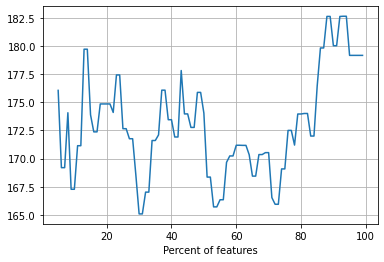

In [ ]:
# model = lgbm = LGBMRegressor(n_estimators=300, max_depth=3, random_state=1234)

# # 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
# cv_scores = []
# for p in tqdm(range(5,100,1)):
#     X_new = SelectPercentile(percentile=p).fit_transform(train_df, y)    
#     cv_score = cross_val_score(model, X_new, y, scoring='neg_mean_absolute_error', cv=5).mean() * (-1)
#     cv_scores.append((p,cv_score))

# # Print the best percentile
# best_score = cv_scores[np.argmin([score for _, score in cv_scores])]
# print(best_score)

# # Plot the performance change with p
# plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
# plt.xlabel('Percent of features')
# plt.grid()

In [ ]:
# # 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
# selectp = SelectPercentile(percentile=60).fit(train_df, y)
# X_train_sel = selectp.transform(train_df)
# X_test_sel = selectp.transform(test_df)

## 데이터 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=1234)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(312, 58) (312,) (105, 58) (105,)


In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predict = lr.predict(X_test)
mean_absolute_error(y_predict, y_test)

161.42756919197092

In [ ]:
rf = RandomForestRegressor(n_estimators=300, max_depth=3, min_samples_leaf=3, random_state=1234)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

In [ ]:
y_predict = rf.predict(X_test)
mean_absolute_error(y_predict, y_test)

162.86649072497767

In [ ]:
et = ExtraTreesRegressor(n_estimators=300, max_depth=3, random_state=1234)
et.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=3, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=300, n_jobs=None, oob_score=False,
                    random_state=1234, verbose=0, warm_start=False)

In [ ]:
y_predict = rf.predict(X_test)
mean_absolute_error(y_predict, y_test)

162.86649072497767

In [ ]:
lgbm = LGBMRegressor(n_estimators=300, max_depth=3, random_state=1234)
lgbm.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_predict = lgbm.predict(X_test)
mean_absolute_error(y_predict, y_test)

161.69397150522147

## 하이퍼파라미터 튜닝

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 130, 150, 200], 
    'max_depth': [3, 5, 7], 
    'max_features': [0.7, 0.9],
    'min_samples_split': [2,4,6],
    'min_samples_leaf':[1,3,5]
}

In [ ]:
rf = RandomForestRegressor(random_state=1234)
rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, scoring='neg_mean_squared_error', cv = 5, n_iter=100, random_state=1234)

# Train on training data-
rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_cv.best_params_

{'max_depth': 7,
 'max_features': 0.9,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 130}

In [ ]:
x = rf_cv.predict(X_test)
mean_absolute_error(x, y_test)

155.08181481254522

In [ ]:
param_grid_et = {
    'n_estimators': [100, 130, 150, 200], 
    'max_depth': [3, 5, 7], 
    'max_features': [0.7, 0.9],
    'min_samples_split': [2,4,6],
    'min_samples_leaf':[1,3,5]
}

In [ ]:
et = ExtraTreesRegressor(random_state=1234)
et_cv = RandomizedSearchCV(estimator=et, param_distributions=param_grid_et, scoring='neg_mean_squared_error', cv = 5, n_iter=100, random_state=1234)

# Train on training data-
et_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                         

In [ ]:
et_cv.best_params_

{'max_depth': 7,
 'max_features': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 130}

In [ ]:
x = et_cv.predict(X_test)
mean_absolute_error(x, y_test)

146.50896348441938

In [ ]:
param_grid_lgb = {
    'boosting_type' : ['gbdt','dart'],
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8], 
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],
}

In [ ]:
lgbm = LGBMRegressor(random_state=1234)
lgbm_cv = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid_lgb, scoring='neg_mean_squared_error', cv = 5, n_iter=100, random_state=1234)

# Train on training data-
lgbm_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=1234,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],

In [ ]:
x = lgbm_cv.predict(X_test)
mean_absolute_error(x, y_test)

158.54595885416708

In [ ]:
lgbm_cv.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 8,
 'n_estimators': 200,
 'subsample': 0.9}

## 추론 및 제출

In [ ]:
pred_lr = lr.predict(test_df)
pred_rf = rf_cv.predict(test_df)
pred_lgbm = lgbm_cv.predict(test_df)
pred_et = et_cv.predict(test_df)

In [ ]:
pred_tot = pred_lr*0.3 + pred_lgbm*0.3 + pred_et*0.4
#pred_tot = pred_rf*0.3 + pred_lgbm*0.3 + pred_et*0.4

In [ ]:
submission['num'] = pred_tot
submission

,code,num
0,C1072,769.970918
1,C1128,1248.062742
2,C1456,580.850981
3,C1840,541.786456
4,C1332,1209.883189
...,...,...
145,C2456,230.268946
146,C1266,419.752391
147,C2152,77.957257
148,C1267,208.583001


In [ ]:
submission.to_csv('new_ensemble_model.csv', index=False)